               Model  Accuracy  Precision    Recall  F1 Score
0      Random Forest  0.892047   0.871658  0.912313  0.891522
1  Gradient Boosting  0.908074   0.957865  0.848259  0.899736
2           CatBoost  0.897490   0.938493  0.844527  0.889034
3            XGBoost  0.901421   0.938440  0.853234  0.893811
               Model                                    Best Parameters
0      Random Forest  {'max_depth': None, 'min_samples_split': 2, 'n...
1  Gradient Boosting  {'learning_rate': 0.2, 'max_depth': 7, 'n_esti...
2           CatBoost  {'depth': 7, 'iterations': 300, 'learning_rate...
3            XGBoost  {'learning_rate': 0.2, 'max_depth': 7, 'n_esti...


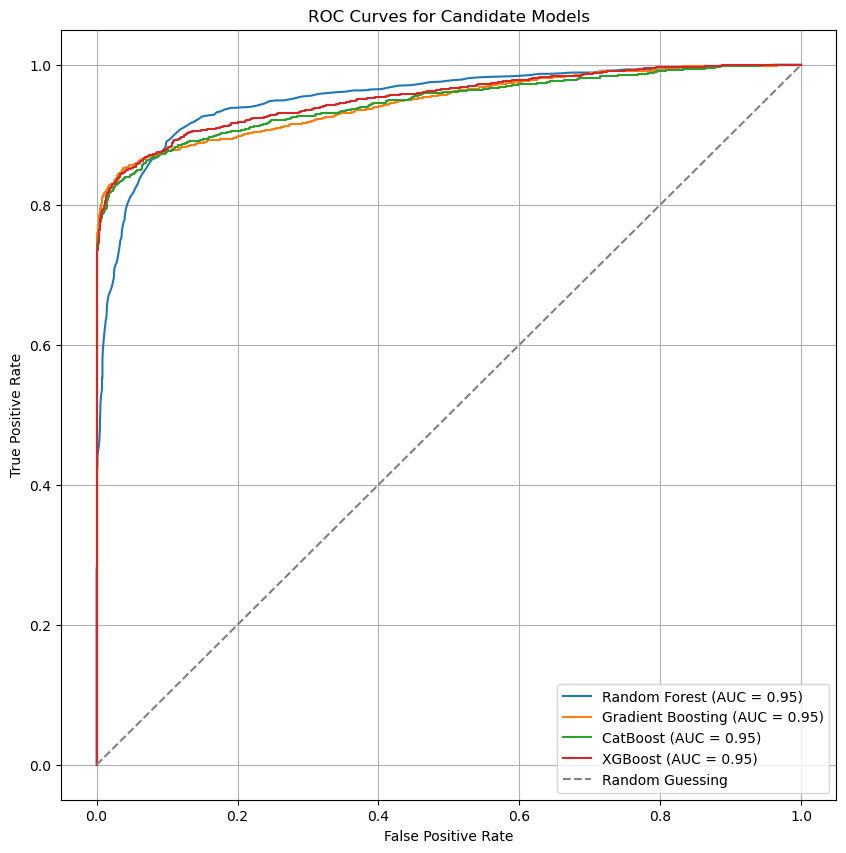

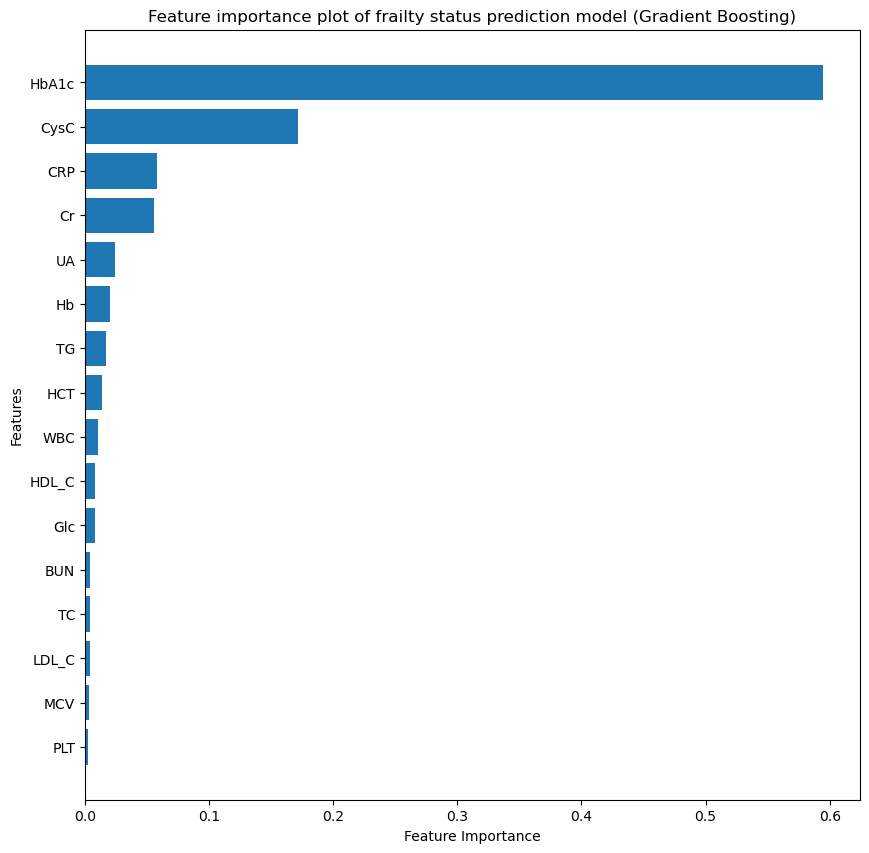

External Validation Metrics for Gradient Boosting:
Accuracy: 0.7019218367083709
Precision: 0.6891385767790262
Recall: 0.7357152070166387
F1 Score: 0.7116656269494697


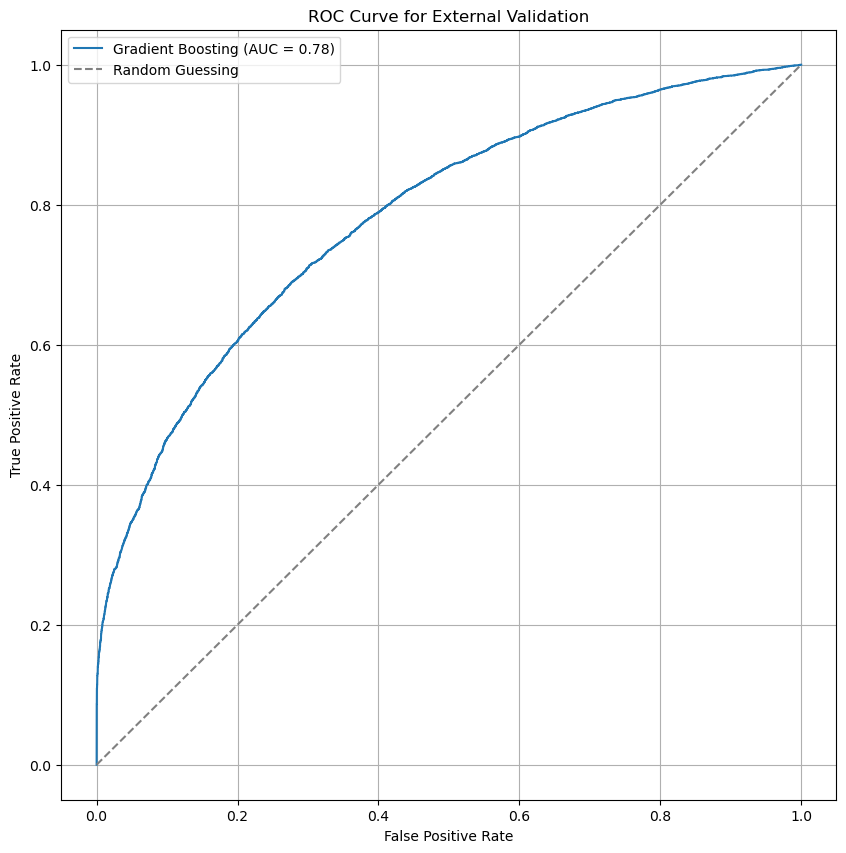

learning_rate: 0.2
max_depth: 7
n_estimators: 200
               Model  \
0      Random Forest   
1  Gradient Boosting   
2           CatBoost   
3            XGBoost   

                                                    Best Parameters  
0  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}  
1       {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}  
2             {'depth': 7, 'iterations': 300, 'learning_rate': 0.2}  
3       {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}  


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Read the CSV file
data = pd.read_csv('data2011.csv')

# Define features and target variable
features = ['WBC', 'MCV', 'PLT', 'BUN', 'Glc', 'Cr', 'TC', 'TG', 'HDL_C', 'LDL_C', 'CRP', 'HbA1c', 'UA', 'HCT', 'Hb', 'CysC']
target = 'fr'

# Split the data into features (X) and target variable (Y)
X = data[features]
Y = data[target]

# Apply SMOTE to balance the data
smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(X, Y)

# Scale the features using Min-Max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_resampled, test_size=0.2, random_state=42)

# Hyperparameter grids
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'CatBoost': {
        'iterations': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'depth': [3, 5, 7]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}

# Initialize the models
models = {
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0),  # No verbose output for CatBoost
    'XGBoost': XGBClassifier()
}

# Initialize lists to store metrics, ROC curve data, and best hyperparameters
metrics = []
roc_data = []
best_params = []

# Train and evaluate each model
for name, model in models.items():
    # Hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], scoring='f1', cv=5, n_jobs=-1)
    grid_search.fit(X_train, Y_train)
    
    # Get the best estimator
    best_model = grid_search.best_estimator_
    best_params.append({
        'Model': name,
        'Best Parameters': grid_search.best_params_
    })

    # Make predictions on the test set
    Y_test_pred = best_model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(Y_test, Y_test_pred)
    precision = precision_score(Y_test, Y_test_pred)
    recall = recall_score(Y_test, Y_test_pred)
    f1 = f1_score(Y_test, Y_test_pred)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(Y_test, best_model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    # Append metrics to the list
    metrics.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

    # Append ROC curve data
    roc_data.append({
        'Model': name,
        'FPR': fpr,
        'TPR': tpr,
        'AUC': roc_auc
    })

# Display the metrics table
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Display the best hyperparameters for each model
best_params_df = pd.DataFrame(best_params)
print(best_params_df)

# Plot ROC curves for all models
plt.figure(figsize=(10, 10))
for roc in roc_data:
    plt.plot(roc['FPR'], roc['TPR'], label='{} (AUC = {:.2f})'.format(roc['Model'], roc['AUC']))

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Candidate Models')
plt.legend()
plt.grid(True)
plt.show()

# Find the best model based on F1 score
best_model_f1 = metrics_df.loc[metrics_df['F1 Score'].idxmax()]

# Get the best model's name
best_model_name = best_model_f1['Model']

# Initialize the best model
best_model = models[best_model_name]

# Train the best model on the full data
best_model.fit(X_scaled, Y_resampled)

# Plot feature importance for the best model
feature_importance = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 10))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title(f'Feature importance plot of frailty status prediction model ({best_model_name})')
plt.show()

# External validation on 'fill2015.csv'
external_data = pd.read_csv('data2015.csv')
X_external = external_data[features]
Y_external = external_data[target]

smote = SMOTE(random_state=42)
X_external_resampled, Y_external_resampled = smote.fit_resample(X_external, Y_external)

# Scale the external data
X_external_scaled = scaler.transform(X_external_resampled)

# Make predictions on the external data
Y_external_pred = best_model.predict(X_external_scaled)

# Calculate and print metrics for the external validation
external_accuracy = accuracy_score(Y_external_resampled, Y_external_pred)
external_precision = precision_score(Y_external_resampled, Y_external_pred)
external_recall = recall_score(Y_external_resampled, Y_external_pred)
external_f1 = f1_score(Y_external_resampled, Y_external_pred)

print(f'External Validation Metrics for {best_model_name}:')
print(f'Accuracy: {external_accuracy}')
print(f'Precision: {external_precision}')
print(f'Recall: {external_recall}')
print(f'F1 Score: {external_f1}')

# Compute ROC curve and AUC for external validation
external_fpr, external_tpr, _ = roc_curve(Y_external_resampled, best_model.predict_proba(X_external_scaled)[:, 1])
external_roc_auc = auc(external_fpr, external_tpr)

# Plot ROC curve for external validation
plt.figure(figsize=(10, 10))
plt.plot(external_fpr, external_tpr, label='{} (AUC = {:.2f})'.format(best_model_name, external_roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for External Validation')
plt.legend()
plt.grid(True)
plt.show()
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")
pd.set_option('display.max_colwidth', None)  # Set the option to display complete text in DataFrame
print(best_params_df)

In [9]:
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

learning_rate: 0.2
max_depth: 7
n_estimators: 200


In [10]:
pd.set_option('display.max_colwidth', None)  # Set the option to display complete text in DataFrame
print(best_params_df)

               Model  \
0      Random Forest   
1  Gradient Boosting   
2           CatBoost   
3            XGBoost   

                                                    Best Parameters  
0  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}  
1       {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}  
2             {'depth': 7, 'iterations': 300, 'learning_rate': 0.2}  
3       {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}  
